## 3. ML Modeling

- In this notebook, we will illustrate how to train an XGBoost model with the diamonds dataset using the Snowpark ML Model API. 
- We also show how to do inference and deploy the model as a UDF.

The Snowpark ML Model API currently supports sklearn, xgboost, and lightgbm models.

### Import Libraries

In [1]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import udf
import snowflake.snowpark.functions as F

# Snowpark ML
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV

# data science libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

# misc
import json
import joblib
import cachetools

# warning suppresion
import warnings; warnings.simplefilter('ignore')

### Establish a Secure Connection to Snowflake

*Other connection options include Username/Password, MFA, OAuth, Okta, SSO. For more information, refer to the [Python Connector](https://docs.snowflake.com/en/developer-guide/python-connector/python-connector-example) documentation.*

In [2]:
# Make a Snowpark Connection

################################################################################################################
#  You can also use the SnowSQL Client to configure your connection params:
#  https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
#
#  >>> from snowflake.ml.utils import connection_params
#  >>> session = Session.builder.configs(connection_params.SnowflakeLoginOptions()
#  >>> ).create()   
#
#  NOTE: If you have named connection params then specify the connection name
#  Example:
#  
#  >>> session = Session.builder.configs(
#  >>> connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
#  >>> ).create()
#
#################################################################################################################

# Create Snowflake Session object
connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : SIKHADAS
Role                        : "ACCOUNTADMIN"
Database                    : "ML_HOL_DB"
Schema                      : "ML_HOL_SCHEMA"
Warehouse                   : "ML_HOL_WH"
Snowflake version           : 7.21.1
Snowpark for Python version : 1.4.0


In [3]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
DEMO_TABLE = 'diamonds' 
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DEMO_TABLE}"

### Load the data & preprocessing pipeline

In [4]:
# Load in the data
diamonds_df = session.table(input_tbl)
diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"DEPTH"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |61.5     |55.0         |326.0    |3.95  |3.98  |2.43  |IDEAL      |
|0.21     |E        |SI1        |59.8     |61.0         |326.0    |3.89  |3.84  |2.31  |PREMIUM    |
|0.23     |E        |VS1        |56.9     |65.0         |327.0    |4.05  |4.07  |2.31  |GOOD       |
|0.29     |I        |VS2        |62.4     |58.0         |334.0    |4.2   |4.23  |2.63  |PREMIUM    |
|0.31     |J        |SI2        |63.3     |58.0         |335.0    |4.34  |4.35  |2.75  |GOOD       |
|0.24     |J        |VVS2       |62.8     |57.0         |336.0    |3.94  |3.96  |2.48  |VERY_GOOD  |
|0.24     |I        |VVS1       |62.3     |57.0         |336.0    |3.95  |3.98  |2.47  |VER

In [5]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']

In [6]:
# Load the preprocessing pipeline object
PIPELINE_FILE = 'preprocessing_pipeline.joblib'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)

### Build a simple XGBoost Regression model

What's happening here? 

- The `model.fit()` function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a [Snowpark Optimized Warehouse](https://docs.snowflake.com/en/user-guide/warehouses-snowpark-optimized) if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
- The `model.predict()` function actualls creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data.

You can check the query history once you execute the following cell to check.

In [7]:
# Split the data into train and test sets
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(weights=[0.9, 0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(diamonds_train_df).transform(diamonds_train_df)
test_df = preprocessing_pipeline.transform(diamonds_test_df)

In [8]:
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)

In [9]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].to_pandas())

,CUT_OE,COLOR_OE,CLARITY_OE,CARAT,DEPTH,TABLE_PCT,X,Y,Z,PREDICTED_PRICE
0,2.0,6.0,5.0,0.020790,0.547222,0.307692,0.391993,0.072496,0.083648,322.593506
1,2.0,6.0,5.0,0.022869,0.455556,0.365385,0.408752,0.075212,0.082390,267.302460
2,1.0,5.0,3.0,0.008316,0.541667,0.269231,0.369646,0.066893,0.077673,385.477814
3,2.0,0.0,4.0,0.006237,0.486111,0.346154,0.368715,0.067402,0.075472,434.468170
4,1.0,4.0,5.0,0.020790,0.552778,0.307692,0.398510,0.071986,0.084277,566.351562
...,...,...,...,...,...,...,...,...,...,...
5407,2.0,1.0,5.0,0.103950,0.505556,0.269231,0.528864,0.097284,0.109748,2636.223389
5408,1.0,5.0,3.0,0.116424,0.452778,0.365385,0.552142,0.099321,0.109748,2343.046143
5409,2.0,1.0,4.0,0.103950,0.550000,0.326923,0.520484,0.095925,0.111006,2690.643066
5410,0.0,3.0,3.0,0.106029,0.511111,0.250000,0.536313,0.097284,0.111006,3194.863525


Let's analyze the results using Snowpark ML's MAPE.

In [10]:
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="PRICE", 
                                        y_pred_col_names="PREDICTED_PRICE")

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

-------------------------------
|"PRICE"  |"PREDICTED_PRICE"  |
-------------------------------
|351.0    |322.593505859375   |
|353.0    |267.3024597167969  |
|355.0    |385.4778137207031  |
|357.0    |434.4681701660156  |
|554.0    |566.3515625        |
|554.0    |492.4712219238281  |
|2757.0   |2734.483642578125  |
|2759.0   |2950.267578125     |
|2759.0   |2802.850830078125  |
|2762.0   |2944.725341796875  |
-------------------------------

Mean absolute percentage error: 0.07117102331735714


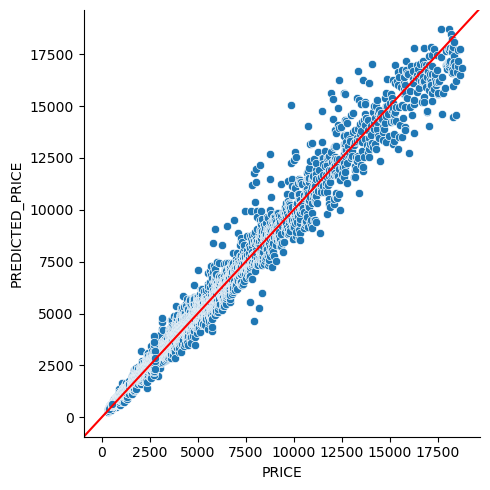

In [11]:
# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Now, let's use Snowpark ML's `GridSearchCV()` function to find optimal model parameters

*Note: This takes ~2.5 min to run.*

In [12]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400, 500],
        "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
grid_search.fit(train_df)

We see that the best estimator has the following parameters: `n_estimators=500` & `learning_rate=0.4`.

We can use `to_sklearn()` in order to get the actual xgboost model object, which gives us access to all its attributes.

In [13]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We can also analyze the grid search results.

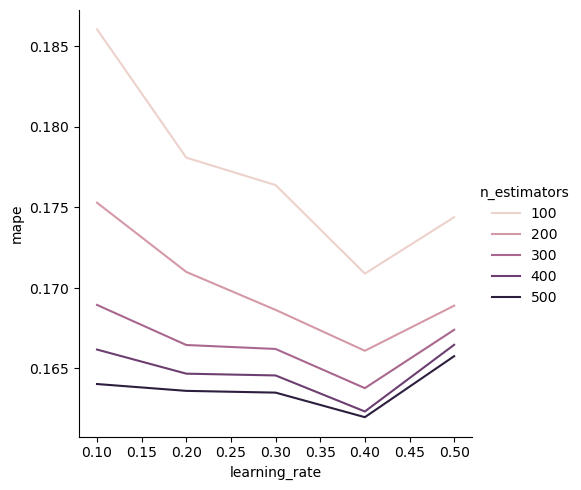

In [14]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

This is consistent with the `learning_rate=0.4` and `n_estimator=500` chosen as the best estimator with the lowest MAPE.

Now, let's predict and analyze the results from using the best estimator.

In [15]:
# Predict
result = grid_search.predict(test_df)

# Analyze results
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="PRICE", 
                                        y_pred_col_names="PREDICTED_PRICE")

result.select("PRICE", "PREDICTED_PRICE").show()
print(f"Mean absolute percentage error: {mape}")

--------------------------------
|"PRICE"  |"PREDICTED_PRICE"   |
--------------------------------
|351.0    |353.2740173339844   |
|353.0    |343.84271240234375  |
|355.0    |431.1207275390625   |
|357.0    |355.054443359375    |
|554.0    |560.3695068359375   |
|554.0    |527.7815551757812   |
|2757.0   |2796.111083984375   |
|2759.0   |2878.782958984375   |
|2759.0   |3021.80224609375    |
|2762.0   |2838.24658203125    |
--------------------------------

Mean absolute percentage error: 0.06614988993792766


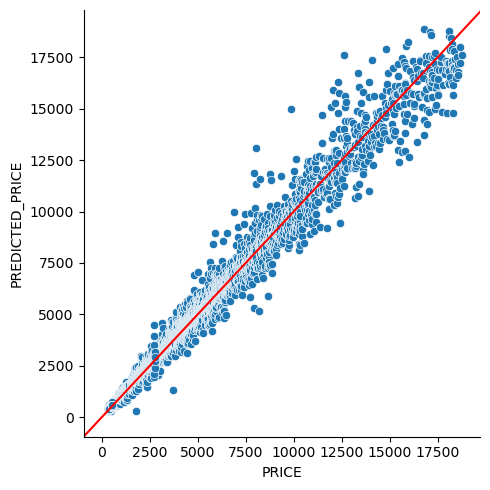

In [16]:
# Plot actual vs predicted 
g = sns.relplot(data=result["PRICE", "PREDICTED_PRICE"].to_pandas().astype("float64"), x="PRICE", y="PREDICTED_PRICE", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Model deployment using permanent Vectorized User-Defined Function (UDF)

One thing to keep in mind is that Snowpark ML's `model.predict()` function creates a ***temporary*** UDF, so in order to persist as a permanent UDF, we'll need to define our own UDF. 

***Note: Once Snowpark ML's native model registry is available, this will be the more streamlined approach to deploy your model.***

We will save the model as an sklearn object so it can be used externally. This is how we'll deploy the model as a UDF in the next step.

In [17]:
# Let's save our optimal model first
optimal_model = grid_search.to_sklearn()
MODEL_FILE = 'model.joblib'
joblib.dump(optimal_model, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@DIAMONDS_ASSETS", overwrite=True)

[PutResult(source='model.joblib', target='model.joblib.gz', source_size=2156458, target_size=706672, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [18]:
# Get all relevant column names to pass into the UDF call
feature_cols = test_df[CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS].columns

##### Create the Vectorized User-Defined Function (UDF)

In [19]:
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_diamond', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@DIAMONDS_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@DIAMONDS_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','xgboost'])
def batch_predict_diamond(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = ["CUT_OE", "COLOR_OE", "CLARITY_OE", 'CARAT', 'DEPTH', 'TABLE_PCT', 'X', 'Y', 'Z']
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

Call Vectorized User-Defined Function (UDF) on test data.

In [20]:
test_df_w_preds = test_df.with_column('PREDICTED_PRICE', batch_predict_diamond(*feature_cols))
test_df_w_preds.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"PREDICTED_PRICE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.02079002079002079   |0.5472222222222223   |0.3076923076923076   |0.3919925512104283   |0.07249575551782682  |0.08364779874213837  |2.0       |6.0         |5.0           |J        |SI1        |351.0    |VERY_GOOD  |353.2740173339844   |
|0.02286902286902287   |0.4555555555555555  

In [21]:
# Write predictions to a Snowflake table
test_df_w_preds.write.mode('overwrite').save_as_table('diamonds_w_predictions')

In [22]:
session.close()